## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries

In [6]:
import collections
import numpy as np
import random
import pickle
import collections
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.style.use('classic')

## importing Tic-tac-toe environment from TCGame_Env
from TCGame_Env import TicTacToe
env = TicTacToe()

In [7]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [8]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    """
    state = next_state = intermediate_state = [1, 2, 3, 4, nan, 8, nan, 9, nan]
    for agent we have left with [5,7] values
    we have space of [4,6,8] (idx position)
    action_space should give for agent as (4, 4),(4, 6),(4, 8),(6, 4),(6, 6),(6, 8),(8, 4),(8, 6),(8, 8)
    
    """

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] # [1] Is for ENV and [0] for agent; 
    return valid_Actions #for agent as (4, 4),(4, 6),(4, 8),(6, 4),(6, 6),(6, 8),(8, 4),(8, 6),(8, 8)

In [9]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    """
    We add new state values IN Q_dict, which are not added in Q_dict as key and actions
    Eg:
    state = next_state = intermediate_state = [1, 2, 3, 4, nan, 8, nan, 9, nan]
    
    """
        
    state1 = Q_state(state) # return in '1-2-3-4-x-8-x-9-x'
    
    if state1 not in Q_dict.keys():
        # for agent this are valid actions (4, 4),(4, 6),(4, 8),(6, 4),(6, 6),(6, 8),(8, 4),(8, 6),(8, 8)
        valid_act = valid_actions(state) 
        # adding actions to its state
        for action in valid_act: 
            Q_dict[state1][action]=0

In [10]:
# Default board positions
print(Q_state(env.state), "\n", env.state)

x-x-x-x-x-x-x-x-x 
 [nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [11]:
# Printing total valid actions for default board positions 9(space)*5(object) = 45(action)
len(valid_actions(env.state))

45

#### Epsilon-greedy strategy

In [12]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time, min_epsilon, max_epsilon, decay_rate):
    """
    USING SAME CODE OF Inventory Management for designing the epsilon_greedy()
    current_state(state)[nan to 8] is send here, 
    """
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon: #Exploitation: this gets the action corresponding to max q-value of current state
        state_next = Q_state(state) # make to text formate x-x-2-x-5-x-x-x-x
        
        # getting the max value q_value from this text state like(1,0), (1,1), ..., (9,7), (9,8)
        action = max(Q_dict[state_next], key=Q_dict[state_next].get) 
    
    else: #Exploration: randomly choosing an action from action_space()
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))] # getting random action in the range of possible_action
    
    return action

#### Tracking the state-action pairs for checking convergence

In [13]:
# Initialising Q_dictionary and States_track
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [14]:
# Initialising states to be tracked
Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                  ('7-x-x-2-x-x-x-x-x',(1,1)),('x-x-5-x-x-6-x-x-x',(0,1)),
                  ('x-x-9-8-x-x-x-6-1',(1, 3)),('x-x-x-5-x-x-x-8-x',(0,1))]

def initialise_tracking_states():
    
    #6 Q-values choosed 
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [15]:
# function to save the Q_dict as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [16]:
initialise_tracking_states()

In [17]:
# definign a function for saving states tracking

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action]) 

#### Define hyperparameters

In [28]:
#Defining parameters 

NUM_EPISODES = 1000000 # 1M eps
LR = 0.01                   # learning rate
GAMMA_VALUE = 0.5           # discount factor keeping 50:50

max_epsilon = 1.0           # Starting position
min_epsilon = 0.001         # Ending position
decay_rate = 0.000009        # Epsilon decay rate

threshold = 200             # after each threshold the status_track and Q_values table will be saved locally

### Epsilon - decay check

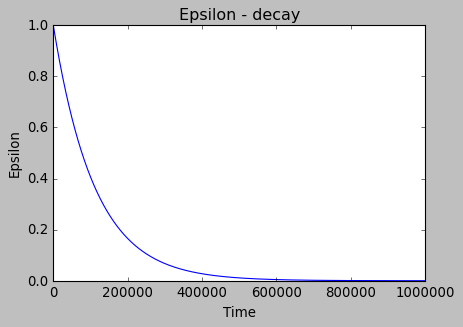

In [29]:
plt.figure(figsize=(6,4))
time = np.arange(0, NUM_EPISODES)
epsilon = []

for i in range(0, NUM_EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))
plt.plot(time, epsilon)
plt.title("Epsilon - decay")
plt.xlabel("Time")
plt.ylabel("Epsilon")
plt.show()

## Build an agent that learns the game by Q-Learning

In [30]:
import time 
start_time = time.time()
print(f"Every {threshold} Episodes the States Tracked and Policy will be saved")
for episode in tqdm(range(NUM_EPISODES)):
    
    env = TicTacToe()         # Initialize the environment
    curr_state = env.state    # Loading default status [nan, nan, nan, nan, nan, nan, nan, nan, nan]
    add_to_dict(curr_state)  
    
    # Flag to end the process
    done = False  

    while done != True:  
        curr_state1 = Q_state(curr_state) # default state is 'x-x-x-x-x-x-x-x-x'
        curr_action = epsilon_greedy(curr_state, episode, min_epsilon, max_epsilon, decay_rate)   # Epsilon with decay
        
        # where  next_state = intermediate_state = [1, 2, 3, 4, nan, 8, nan, 9, nan] refer to evn.py
        # rewards;  done = won/loss/tied (True) or Resume(False)
        next_state, reward, done = env.step(curr_state, curr_action) 
        next_state_temp = Q_state(next_state) # '1-2-3-4-x-8-x-9-x'
        
        # add the current state to dictionary Q_values if not PRESENT in Q_values table
        add_to_dict(next_state)     

        # Updateing Q-Table
        if done != True:
            # getting the max value FROM q_value ACTION with state as next_state_temp as FUTURE REWARD
            max_next = max(Q_dict[next_state_temp], key=Q_dict[next_state_temp].get)  # return (position, values)
            
            # updateding the AGNET taken ACTION reward 
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA_VALUE*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action])
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to the next state
        curr_state = next_state
        

    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')   # saving states_tracked
        save_obj(Q_dict,'Q_dict_policy')           # saving Q-dict policy
#         print(f"Saving States Tracked and Policy on episode: {episode}  TIME: {round((time.time() - start_time)/60, 2)}mins" )

elapsed_time = time.time() - start_time

print(f"Total time take: {int(elapsed_time//3600)}h {int(elapsed_time/60%60)}mins")

save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Q_dict_policy')

Every 200 Episodes the States Tracked and Policy will be saved


100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [4:04:30<00:00, 68.16it/s]


Total time take: 4h 4mins


#### Check the Q-dictionary

In [31]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.1341291840583898,
              (0, 3): -1.1341436151728532,
              (0, 5): -1.1341801243087701,
              (0, 7): -1.1341618723337101,
              (0, 9): -1.1340886216285377,
              (1, 1): -1.134064655219998,
              (1, 3): -1.1340593521888922,
              (1, 5): -1.1340949104591063,
              (1, 7): -1.1342057264482335,
              (1, 9): -1.1341514903275478,
              (2, 1): -1.1340462314122015,
              (2, 3): -1.134117598218838,
              (2, 5): -1.1342174630057527,
              (2, 7): -1.134129028629209,
              (2, 9): -1.1341667731046425,
              (3, 1): -1.1340395740460518,
              (3, 3): -1.134061851124301,
              (3, 5): -1.1340866831194267,
              (3, 7): -1.1311892001172408,
              (3, 9): -1.1341534092284027,
              (4, 1): -1.1340397140976992,
              (4, 3): -1.1341668431039988,
              (4, 5

In [32]:
len(Q_dict)

1372272

#### We got around 1.37M combination of Q_values for running 1M episodes.

#### Check the states tracked for Q-values convergence
Checking for all 6 Q-values we choosed.

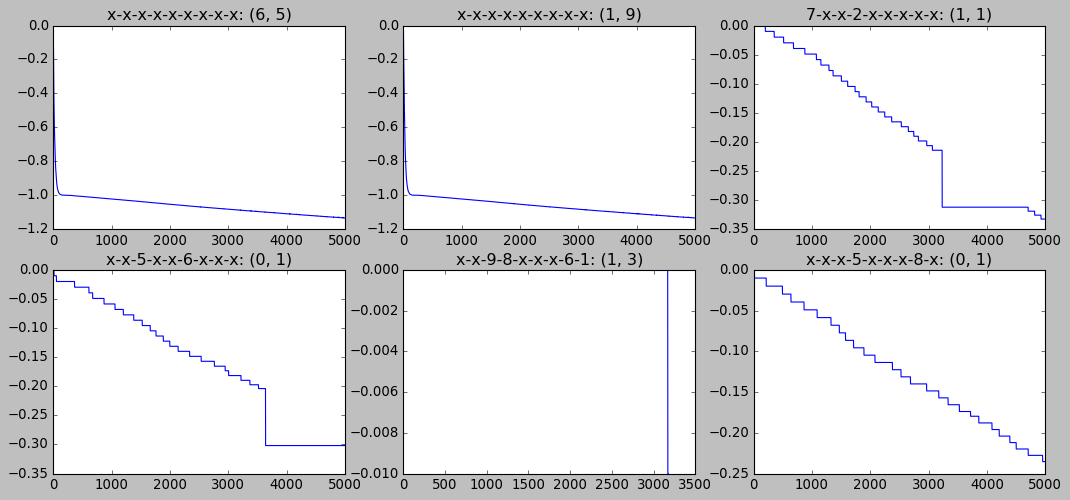

In [33]:
plt.figure(0, figsize=(16,7))
idx = 1
for q_values in Sample_Qvalues:
    
    idxplot = 230+idx
#     print(idxplot)
    
    x_axis = np.asarray(range(0, len(States_track[q_values[0]][q_values[1]]) ))
    ax = plt.subplot(idxplot)
    ax.set_title(f"{q_values[0]}: {q_values[1]}")
    ax.plot(x_axis, np.asarray(States_track[q_values[0]][q_values[1]] ))
    plt.show
    idx += 1

### Epsilon - decay check

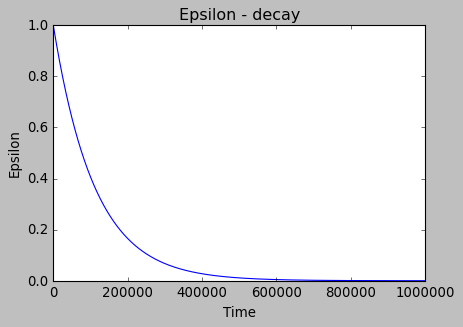

In [34]:
plt.figure(figsize=(6,4))
time = np.arange(0, NUM_EPISODES)
epsilon = []

for i in range(0, NUM_EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))
plt.plot(time, epsilon)
plt.title("Epsilon - decay")
plt.xlabel("Time")
plt.ylabel("Epsilon")
plt.show()

### This marks the end of this assignment.